In [1]:
import os
import datetime
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [ ]:
# Parameters & Paths
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], 3)
batch_size = 8
epochs = 5
learning_rate = 0.001
output_name = 'ConvNextTiny'
data_path = r"GLAZE-evaluation\dataset\train"
model_output_path = r"GLAZE-evaluation\model\\" + output_name + datetime.datetime.now().strftime("-%Y%m%d-%H%M%S") + ".h5"

In [ ]:
# Logging
log_path = r"GLAZE-evaluation\log\\" + output_name + datetime.datetime.now().strftime("-%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)

# Dataset Prep

In [4]:
images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        full_image_path = os.path.join(subfolder_path, image_filename)
        images.append(full_image_path)
        labels.append(subfolder)
        
data = pd.DataFrame({'image': images, 'label': labels})

In [5]:
train_df, valid_test_df = train_test_split(
    data, 
    test_size=0.2, # 20% for validation/test
    stratify=data['label'], 
    random_state=123
)

valid_df, test_df = train_test_split(
    valid_test_df, 
    test_size=0.5, # Split the 20% into two 10% halves
    stratify=valid_test_df['label'], 
    random_state=123
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Total images found: {len(data)}")
print(f"Train DF size: {len(train_df)}")
print(f"Validation DF size: {len(valid_df)}")
print(f"Test DF size: {len(test_df)}")

Total images found: 400
Train DF size: 320
Validation DF size: 40
Test DF size: 40


In [6]:
data.shape

(400, 2)

In [7]:
# Create a new generator for ConvNeXt (no explicit rescaling needed)
# The ConvNeXt model will handle its own normalization internally
convnext_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# NOTE: Do NOT use 'rescale=1/255.0' here!
# If your images are read as uint8 (0-255), keep rescale=None or 1.0
valid_test_datagen = ImageDataGenerator(rescale=None)

train_gen = convnext_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    color_mode='rgb', 
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 320 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [8]:
print(len(train_df))
print(len(valid_df))
print(len(test_df))

320
40
40


# ConvNextTiny

In [9]:
base_model = ConvNeXtTiny(
    include_top=False,           
    weights='imagenet',          
    input_shape=img_shape,
)

In [10]:
output_tensor = base_model.output

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [13]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
output_tensor = base_model.output

In [16]:
checkpoint = ModelCheckpoint(
    'roko_style.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
)

In [17]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7049 - loss: 2.4339
Epoch 1: val_accuracy improved from None to 0.77500, saving model to roko_style.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7594 - loss: 2.3127 - val_accuracy: 0.7750 - val_loss: 2.1740 - learning_rate: 0.0010
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8539 - loss: 1.8955
Epoch 2: val_accuracy improved from 0.77500 to 0.85000, saving model to roko_style.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8500 - loss: 1.7054 - val_accuracy: 0.8500 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9100 - loss: 0.8304
Epoch 3: val_accuracy improved from 0.85000 to 0.90000, saving model to roko_style.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8875 - loss: 1.0241 - val_accuracy: 0.9000 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9255 - loss: 0.4167
Epoch 4: val_accuracy improved from 0.90000 to 0.95000, saving model to roko_style.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9281 - loss: 0.4641 - val_accuracy: 0.9500 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9398 - loss: 0.4618
Epoch 5: val_accuracy did not improve from 0.95000
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9500 - loss: 0.3335 - val_accuracy: 0.9000 - val_loss: 0.5517 - learning_rate: 0.0010


In [18]:
model.load_weights('roko_style.h5')
model.save(model_output_path)

# Eval

In [19]:
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Train Loss: {train_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

Train Accuracy: 0.9500
Train Loss: 0.3335
Validation Accuracy: 0.9000
Validation Loss: 0.5517


In [20]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9250 - loss: 0.3837
Test Accuracy: 0.9250
Test Loss: 0.3837


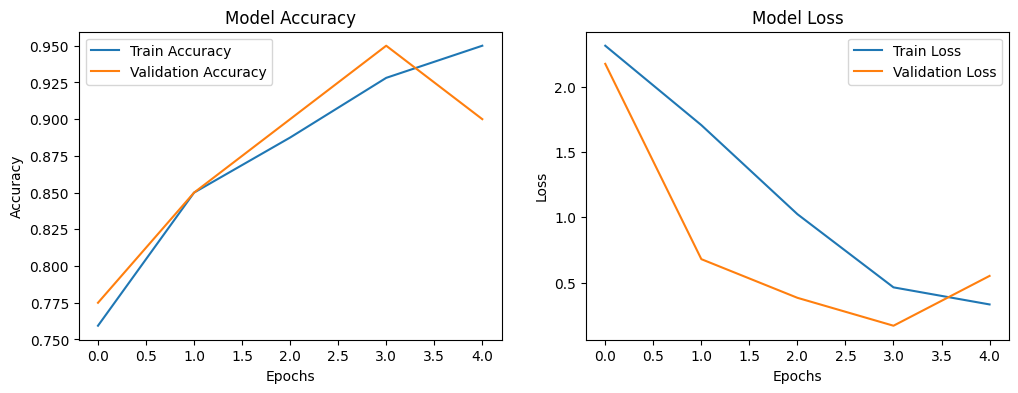

In [21]:
plt.figure(figsize=(12,4))
    
    # Subplot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.round(y_pred)
y_true = test_gen.classes

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [23]:
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

512-lora-glz       0.95      0.90      0.92        20
     512-ori       0.90      0.95      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



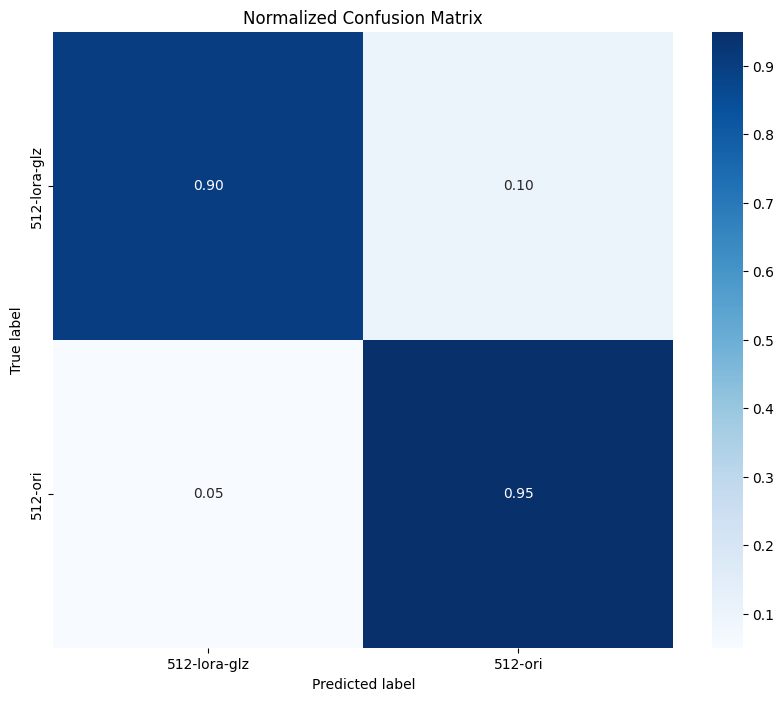

In [24]:
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()